# Predicting T-shirt size using the ANSUR II dataset
We will here try to predict a persons t-shirt size given the weight and height of the person. We will use the ANSUR II dataset which contains a lot of information about the physical attributes of a large number of people. 

We will first try to map the persons in the dataset to a t-shirt size. It is hard to find a concise size chart for t-shirt so we will create our own, initial chart, based on these assumptions:

We will only look at two measurements, Shoulder Width and Chest Circumference.

Our first problem is that Shoulder Width is not one of the measurements taken in the dataset. But we have Biacromial Breadth which is the distance between the two acromion processes. We will assume that this is the same as Shoulder Width.

We will then have these initial rules:

| Size | Percentile |
|------|------------|
| XS   | 0-5        |
| S    | 5-25       |
| M    | 25-50      |
| L    | 50-75      |
| XL   | 75-90      |
| XXL  | 90-97      |
| XXXL | 97-100     |

## Inspect the data

In [2]:
import pandas as pd

In [3]:
female = pd.read_csv('./data/female.csv')

male = pd.read_csv('./data/male.csv')


In [4]:
print(f'For women we have (rows, columns) {female.shape}')

print(f'For men we have (rows, columns) {male.shape}')

For women we have (rows, columns) (1986, 108)
For men we have (rows, columns) (4082, 108)


#can add a clean the data 
#take the outliers 

## Checking the percentiles

Let us determine the percentiles of the data

In [5]:
def compute_percentile_ranges(column):
    #Define percentile ranges
    ranges = [(0, 5), (5, 25), (25, 50), (50, 75), (75, 90), (90, 97), (97, 100)]

    percentiles = {(low, high): (column.quantile(low/100), column.quantile(high/100)) for low, high in ranges}

    counts = {}

    for r, (low, high) in percentiles.items():
        counts[r] = ((column >= low) & (column < high)).sum()
    
    return counts


print(compute_percentile_ranges(female['chestcircumference']))
print(compute_percentile_ranges(female['biacromialbreadth']))

print(compute_percentile_ranges(male['chestcircumference']))
print(compute_percentile_ranges(male['biacromialbreadth']))





{(0, 5): np.int64(100), (5, 25): np.int64(396), (25, 50): np.int64(492), (50, 75): np.int64(499), (75, 90): np.int64(299), (90, 97): np.int64(140), (97, 100): np.int64(59)}
{(0, 5): np.int64(93), (5, 25): np.int64(377), (25, 50): np.int64(477), (50, 75): np.int64(541), (75, 90): np.int64(297), (90, 97): np.int64(139), (97, 100): np.int64(61)}
{(0, 5): np.int64(199), (5, 25): np.int64(810), (25, 50): np.int64(1025), (50, 75): np.int64(1012), (75, 90): np.int64(616), (90, 97): np.int64(295), (97, 100): np.int64(124)}
{(0, 5): np.int64(191), (5, 25): np.int64(787), (25, 50): np.int64(989), (50, 75): np.int64(1079), (75, 90): np.int64(610), (90, 97): np.int64(303), (97, 100): np.int64(122)}


## Generate the t-shirt size chart

In [6]:
def comput_size_percentile_measurements(data, chest_column, shoulder_column):
    sizes = ['XS', 'S', 'M', 'L', 'XL', '2XL', '3XL']
    ranges = [0, 5, 25 , 50, 75, 90, 97]

    # Compute the values for each percentile for chest and shoulder
    chest_percentiles = {p: data[chest_column].quantile(p/100) for p in ranges}
    shoulder_percentiles = {p: data[shoulder_column].quantile(p/100) for p in ranges}

    # Map the t-shirt sizes to the corresponding chest and shoulder measurements
    size_mappings = {}
    for i, size in enumerate(sizes):
        size_mappings[size] = {
            'Chest': int(chest_percentiles[ranges[i]]),
            'Shoulder': int(shoulder_percentiles[ranges[i]])
        }
    
    return size_mappings



print(comput_size_percentile_measurements(female, 'chestcircumference', 'biacromialbreadth'))
print(comput_size_percentile_measurements(male, 'chestcircumference', 'biacromialbreadth'))

{'XS': {'Chest': 695, 'Shoulder': 283}, 'S': {'Chest': 824, 'Shoulder': 335}, 'M': {'Chest': 889, 'Shoulder': 353}, 'L': {'Chest': 940, 'Shoulder': 365}, 'XL': {'Chest': 999, 'Shoulder': 378}, '2XL': {'Chest': 1057, 'Shoulder': 389}, '3XL': {'Chest': 1117, 'Shoulder': 400}}
{'XS': {'Chest': 774, 'Shoulder': 337}, 'S': {'Chest': 922, 'Shoulder': 384}, 'M': {'Chest': 996, 'Shoulder': 403}, 'L': {'Chest': 1056, 'Shoulder': 415}, 'XL': {'Chest': 1117, 'Shoulder': 428}, '2XL': {'Chest': 1172, 'Shoulder': 441}, '3XL': {'Chest': 1233, 'Shoulder': 452}}


In [7]:

female_sizes = {  
    'XS': {'Chest': 695, 'Shoulder': 283}, # Chest:695-823
    'S': {'Chest': 824, 'Shoulder': 335}, # Chest: 824-888           
    'M': {'Chest': 889, 'Shoulder': 353}, 
    'L': {'Chest': 940, 'Shoulder': 365}, 
    'XL': {'Chest': 999, 'Shoulder': 378}, 
    '2XL': {'Chest': 1057, 'Shoulder': 389}, 
    '3XL': {'Chest': 1117, 'Shoulder': 400} 
    }

male_sizes = {
    'XS': {'Chest': 774, 'Shoulder': 337}, 
    'S': {'Chest': 922, 'Shoulder': 384}, 
    'M': {'Chest': 996, 'Shoulder': 403}, 
    'L': {'Chest': 1056, 'Shoulder': 415}, 
    'XL': {'Chest': 1117, 'Shoulder': 428}, 
    '2XL': {'Chest': 1172, 'Shoulder': 441}, 
    '3XL': {'Chest': 1233, 'Shoulder': 452}
    }

In [8]:
def get_size(data, size_chart):
    matches = {size: 0 for size in size_chart.keys()}
    ties = 0

    for _, row in data.iterrows():
        possible_sizes = []

        for size, measurements in size_chart.items():
            if (row['biacromialbreadth'] <= measurements['Shoulder'] and
                row['chestcircumference'] <= measurements['Chest']):
                possible_sizes.append(size)
        
        if len(possible_sizes) == 1:
            matches[possible_sizes[0]] += 1
        elif len(possible_sizes) > 1:
            ties += 1
    
    return matches, ties

In [9]:
female_matches, female_ties = get_size(female, female_sizes)
male_matches, male_ties = get_size(male, male_sizes)

print('Female matches: ', female_matches)
print('Female ties: ', female_ties)
print('Male matches: ', male_matches)
print('Male ties: ', male_ties)


Female matches:  {'XS': 0, 'S': 0, 'M': 0, 'L': 0, 'XL': 0, '2XL': 0, '3XL': 236}
Female ties:  1642
Male matches:  {'XS': 0, 'S': 0, 'M': 0, 'L': 0, 'XL': 0, '2XL': 0, '3XL': 434}
Male ties:  3437


This is not good. Let us have overlapping measurements.

In [10]:
def create_overlapping_size_chart(original_chart):
    overlapping_chart = {}

    sizes = list(original_chart.keys())

    for i, size in enumerate(sizes):
        overlapping_chart[size] = {}
        if i == 0:
            overlapping_chart[size]['Chest'] = [original_chart[size]['Chest'], original_chart[sizes[i+1]]['Chest']+5]
            overlapping_chart[size]['Shoulder'] = [original_chart[size]['Shoulder'], original_chart[sizes[i+1]]['Shoulder']+5]

        elif i ==len(sizes)-1:
            overlapping_chart[size]['Chest'] = [original_chart[size]['Chest']-5, original_chart[size]['Chest']+1000]
            overlapping_chart[size]['Shoulder'] = [original_chart[size]['Shoulder']-5, original_chart[size]['Shoulder']+1000]

        else:
            overlapping_chart[size]['Chest'] = [original_chart[size]['Chest']-5, original_chart[sizes[i+1]]['Chest']+5]
            overlapping_chart[size]['Shoulder'] = [original_chart[size]['Shoulder']-5, original_chart[sizes[i+1]]['Shoulder']+5]
        
    return overlapping_chart





In [11]:
new_female_sizes = create_overlapping_size_chart(female_sizes)
new_male_sizes = create_overlapping_size_chart(male_sizes)

for k, v in new_female_sizes.items():
    print(f"'{k}' : {v}, ")

print()

for k, v in new_male_sizes.items():
    print(f"'{k}' : {v}, ")




'XS' : {'Chest': [695, 829], 'Shoulder': [283, 340]}, 
'S' : {'Chest': [819, 894], 'Shoulder': [330, 358]}, 
'M' : {'Chest': [884, 945], 'Shoulder': [348, 370]}, 
'L' : {'Chest': [935, 1004], 'Shoulder': [360, 383]}, 
'XL' : {'Chest': [994, 1062], 'Shoulder': [373, 394]}, 
'2XL' : {'Chest': [1052, 1122], 'Shoulder': [384, 405]}, 
'3XL' : {'Chest': [1112, 2117], 'Shoulder': [395, 1400]}, 

'XS' : {'Chest': [774, 927], 'Shoulder': [337, 389]}, 
'S' : {'Chest': [917, 1001], 'Shoulder': [379, 408]}, 
'M' : {'Chest': [991, 1061], 'Shoulder': [398, 420]}, 
'L' : {'Chest': [1051, 1122], 'Shoulder': [410, 433]}, 
'XL' : {'Chest': [1112, 1177], 'Shoulder': [423, 446]}, 
'2XL' : {'Chest': [1167, 1238], 'Shoulder': [436, 457]}, 
'3XL' : {'Chest': [1228, 2233], 'Shoulder': [447, 1452]}, 


In [12]:
female_sizes = {
'XS' : {'Chest': [695, 829], 'Shoulder': [283, 340]}, # 695-823
'S' : {'Chest': [819, 894], 'Shoulder': [330, 358]}, # 824-888
'M' : {'Chest': [884, 945], 'Shoulder': [348, 370]}, 
'L' : {'Chest': [935, 1004], 'Shoulder': [360, 383]}, 
'XL' : {'Chest': [994, 1062], 'Shoulder': [373, 394]}, 
'2XL' : {'Chest': [1052, 1122], 'Shoulder': [384, 405]}, 
'3XL' : {'Chest': [1112, 2117], 'Shoulder': [395, 1400]}
}

male_sizes = {
'XS' : {'Chest': [774, 927], 'Shoulder': [337, 389]}, 
'S' : {'Chest': [917, 1001], 'Shoulder': [379, 408]}, 
'M' : {'Chest': [991, 1061], 'Shoulder': [398, 420]}, 
'L' : {'Chest': [1051, 1122], 'Shoulder': [410, 433]}, 
'XL' : {'Chest': [1112, 1177], 'Shoulder': [423, 446]}, 
'2XL' : {'Chest': [1167, 1238], 'Shoulder': [436, 457]}, 
'3XL' : {'Chest': [1228, 2233], 'Shoulder': [447, 1452]}
}

In [13]:
#1.26
def get_size(data, size_chart):
    matches = {size: 0 for size in size_chart.keys()}
    ties = 0

    size_ordered = list(size_chart.keys())

    for _, row in data.iterrows():
        possible_sizes = []

        for size, measurements in size_chart.items():
            if (row['biacromialbreadth'] >= measurements['Shoulder'][0] and
                row['biacromialbreadth'] <= measurements['Shoulder'][1] and
                row['chestcircumference'] >= measurements['Chest'][0] and
                row['chestcircumference'] <= measurements['Chest'][1]):
                possible_sizes.append(size)

        if len(possible_sizes) == 1:
                matches[possible_sizes[0]] += 1
        elif len(possible_sizes) > 1:
                # Check if sizes are adjacent
                are_adjacent = all([abs(size_ordered.index(possible_sizes[i]) - size_ordered.index(possible_sizes[i + 1])) == 1
                                    for i in range(len(possible_sizes)-1)])
                
                if are_adjacent:
                    # Assign the larger size
                    larger_size = max(possible_sizes, key=lambda s: size_ordered.index(s))
                    matches[larger_size] += 1

                    # Otherwise...
                else:
                    ties += 1
        
    return matches, ties

            


In [14]:
# Extra info about all-function

# result = all([True, False, True])
# print(result)

x = 10

result = all([x < 15, x == 10, x > 9])
print(result)



True


In [15]:
female_matches, female_ties = get_size(female, new_female_sizes)
male_matches, male_ties = get_size(male, new_male_sizes)

print('Female matches: ', female_matches)
print('Female ties: ', female_ties)
print('Male matches: ', male_matches)
print('Male ties: ', male_ties)

Female matches:  {'XS': 23, 'S': 185, 'M': 247, 'L': 276, 'XL': 118, '2XL': 35, '3XL': 13}
Female ties:  0
Male matches:  {'XS': 63, 'S': 428, 'M': 578, 'L': 593, 'XL': 331, '2XL': 101, '3XL': 50}
Male ties:  0


In [16]:
def determine_size(value, measurement, size_dict):
    """
    Determine clothing sizes that match the given body measurement value.
    
    Iterates through the provided size dictionary and finds all sizes where the 
    measurement range contains the given value.
    
    Parameters:
      value: The body measurement value
      measurement: The name of the measurement type
      size_dict: Dictionary mapping clothing sizes to measurement ranges
    
    Returns:
      sizes: List of clothing sizes matching the measurement value
    """
    sizes = []
    for size, measurements in size_dict.items():
        if measurements[measurement][0] <= value <= measurements[measurement][1]:
            sizes.append(size)
    return sizes

def determine_individual_size(row, size_dict):
    """
    Determine individual clothing size based on chest circumference and shoulder width.
    Matches the chest and shoulder measurements to clothing sizes in the provided size dictionary. 
    Returns a single matching size, or the larger of two adjacent sizes if there are multiple matches.
    Returns None if no size matches or adjacent sizes cannot be determined.
    """
    chest_size = determine_size(row['chestcircumference'], 'Chest', size_dict)
    shoulder_size = determine_size(row['biacromialbreadth'], 'Shoulder', size_dict)
    
    matching_sizes = list(set(chest_size) & set(shoulder_size))
    
    if len(matching_sizes) == 1:
        return matching_sizes[0]
    elif len(matching_sizes) > 1:
        # Check if sizes are adjacent, if so, select the larger size
        size_order = list(size_dict.keys())
        adjacent = all([abs(size_order.index(a) - size_order.index(b)) <= 1 for a in matching_sizes for b in matching_sizes])
        if adjacent:
            return max(matching_sizes, key=lambda x: size_order.index(x))
    return None

In [17]:
#add t-shirt size column
female['t-shirt size'] = female.apply(determine_individual_size, args=(new_female_sizes,), axis=1)

male['t-shirt size'] = male.apply(determine_individual_size, args=(new_male_sizes,), axis=1)



In [18]:
male['t-shirt size'].value_counts()

t-shirt size
L      593
M      578
S      428
XL     331
2XL    101
XS      63
3XL     50
Name: count, dtype: int64

In [19]:
#people without the size who are not included under any size
female_filtered = female.dropna(subset=['t-shirt size'])

male_filtered = male.dropna(subset=['t-shirt size'])

In [20]:
female_filtered.shape

(897, 109)

In [21]:
male_filtered.shape


(2144, 109)

In [22]:
columns = ['chestcircumference', 'biacromialbreadth', 'weightkg', 'stature','t-shirt size']

female_dataset = female_filtered[columns]
male_dataset = male_filtered[columns]

#weightkg and stature number is need to divided 10 see below 



In [23]:
female_dataset.to_csv('./data/female_sized.csv', index=False)
male_dataset.to_csv('./data/male_sized.csv', index=False)


## Why Create a Scatter Plot

Visualize the Distribution of t-shirt Sizes

Identify Patterns or Trends

Compare Men and Women (data)

Communicate Results

Identify Potential Anomalies or Outliers

/var/folders/32/xmqv05_97mx18_n2m6kt14r00000gn/T/ipykernel_68575/481386849.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[173.5 181.  185.  ... 176.5 169.  182.8]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  male_dataset.loc[:, 'stature'] = male_dataset['stature'] / 10
/var/folders/32/xmqv05_97mx18_n2m6kt14r00000gn/T/ipykernel_68575/481386849.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 92.9 116.2  95.4 ...  89.6  83.2  98.5]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  male_dataset.loc[:, 'weightkg'] = male_dataset['weightkg'] / 10
/var/folders/32/xmqv05_97mx18_n2m6kt14r00000gn/T/ipykernel_68575/481386849.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[166.  167

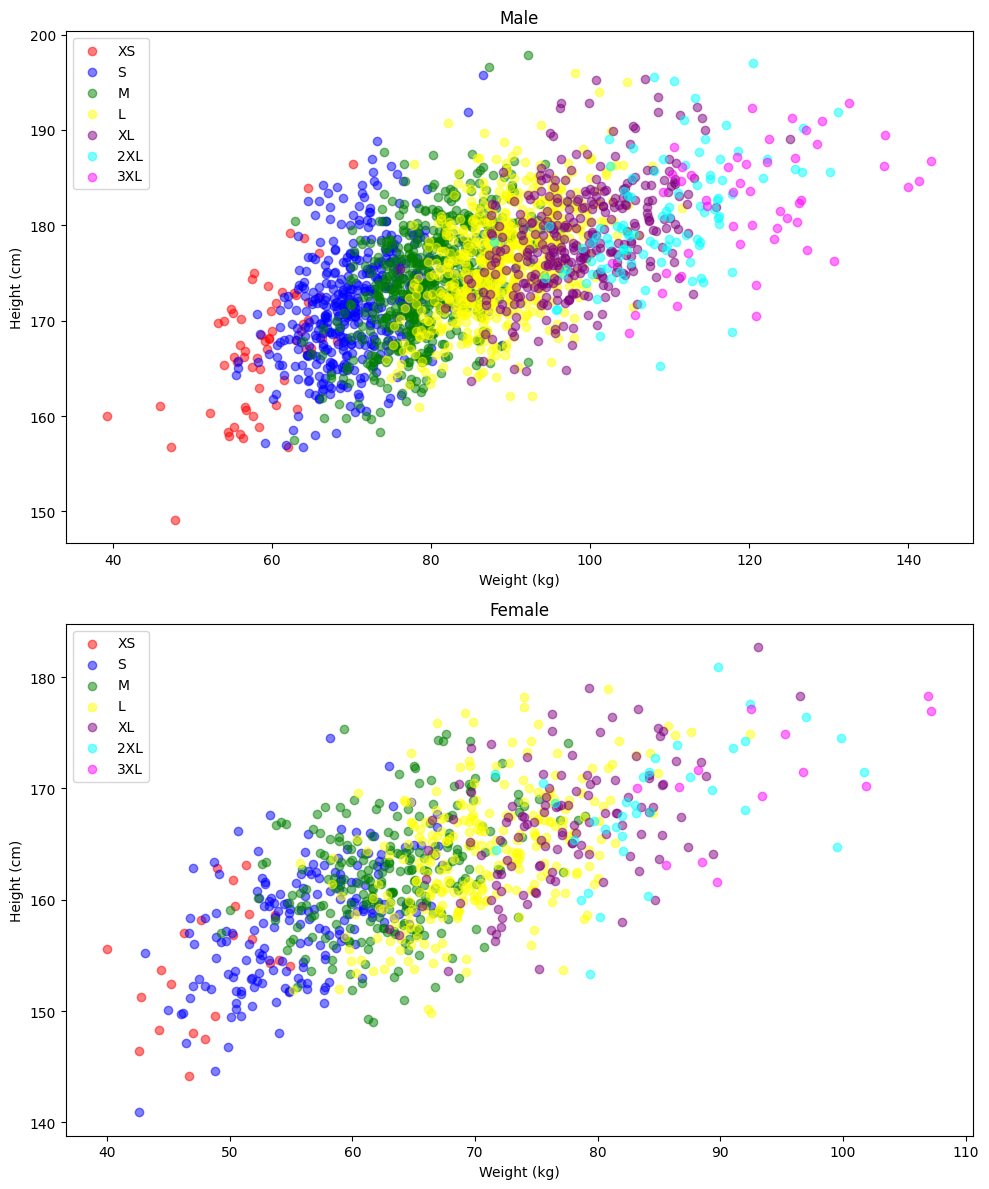

In [24]:
import matplotlib.pyplot as plt


# First let us define a dict to match a t-shirt size to a color
colors = {
    'XS': 'red',
    'S': 'blue',
    'M': 'green',
    'L': 'yellow',
    'XL': 'purple',
    '2XL': 'cyan',
    '3XL': 'magenta'
}

male_dataset = pd.read_csv('./data/male_sized.csv')
female_dataset = pd.read_csv('./data/female_sized.csv')
# For male_dataset change the data by /10
male_dataset.loc[:, 'stature'] = male_dataset['stature'] / 10
male_dataset.loc[:, 'weightkg'] = male_dataset['weightkg'] / 10

# For female_dataset
female_dataset.loc[:, 'stature'] = female_dataset['stature'] / 10
female_dataset.loc[:, 'weightkg'] = female_dataset['weightkg'] / 10

# Create plots for each gender
fig, axes = plt.subplots(nrows=2, figsize=(10, 12))

for ax, gender_data, gender in zip(axes, [male_dataset, female_dataset], ["Male", "Female"]):
    for size, color in colors.items():
        # Filter data by size
        size_data = gender_data[gender_data["t-shirt size"] == size]

        # Plot data
        ax.scatter(size_data["weightkg"], size_data["stature"], c=color, label=size, alpha=0.5)

    ax.set_title(gender)
    ax.set_xlabel("Weight (kg)")
    ax.set_ylabel("Height (cm)")
    # legend = to identify each t-shirt size
    ax.legend()

plt.tight_layout()
plt.show()

In [25]:
#1.27 try kNN method, get the idea is fine, will be import this function below is called KNeighborsClassifier 
#class KNNClassifier:   
#fit(x,y)
#predict(x) #we can input a weight or number of length 

import numpy as np

class KNNClassifier:
    def __init__(self, k=5):
        # 1. Constructor for KNNClassifier. Initializes class variables.
        self.k = k
        self.X = None
        self.y = None

    def _calculate_distance(self, x1, x2):
        """
        Calculate the Euclidean distance between two data points, x1 and x2
        """
        # 2. Calculate the Euclidean distance between two data points x1 and x2.
        return ((x1 - x2)**2).sum() ** 0.5

    def _knn_predict(self, x):
        # 3. Predict the class for a given data point x using KNN.
        return sorted([
            (self._calculate_distance(x, measurement), self.y[i])
            for i, measurement in enumerate(self.X)
        ])[:self.k]

    def fit(self, X, y):
        # 4. Train the KNN model with the given training data and labels.
        self.X = np.array(X)
        self.y = np.array(y)

    def _predict(self, neighbors):
        # 5. Determine the final prediction based on the majority class of nearest neighbors.
        labels = [n[1] for n in neighbors]
        label, count = np.unique(labels, return_counts=True)
        max_count = np.max(count)

        if np.sum(count == max_count) > 1:
            tied_labels = label[count == max_count]
            # 5a. In case of a tie, select the smallest class based on the order in labels.
            return min(tied_labels, key=labels.index)

        # 5b. Otherwise, select the class with the most votes.
        return label[np.argmax(count)]

    def predict(self, X):
        # 6. Make predictions for a given list of data points X.
        predictions = []
        for x in X:
            neighbors = self._knn_predict(x)
            prediction = self._predict(neighbors)
            # 6a. Add the prediction to the result list.
            predictions.append(prediction)

        return predictions


In [26]:
#stature = height stature is a name from data
females_X = [ (person['stature'], person['weightkg']) for _, person in female_dataset.iterrows()]
females_Y = female_dataset['t-shirt size'].values.tolist()

In [27]:
females_Y

['XL',
 'L',
 'S',
 'XL',
 '2XL',
 'L',
 'L',
 'M',
 'S',
 'L',
 'L',
 'S',
 'XL',
 'M',
 'L',
 'L',
 'M',
 'M',
 'S',
 'XL',
 'L',
 'L',
 'L',
 '2XL',
 'XS',
 'L',
 'XL',
 'L',
 'L',
 'M',
 'L',
 '2XL',
 'M',
 'S',
 'M',
 'L',
 'L',
 'L',
 'XL',
 'M',
 'XL',
 'S',
 'M',
 'L',
 '2XL',
 'L',
 'S',
 'L',
 'S',
 'XL',
 'S',
 'M',
 'L',
 'XL',
 'M',
 'L',
 'L',
 'L',
 'S',
 'L',
 'S',
 '2XL',
 'L',
 'S',
 'S',
 '3XL',
 'M',
 'L',
 'M',
 'M',
 'M',
 'M',
 'L',
 'M',
 'S',
 'L',
 'M',
 'M',
 'XL',
 'S',
 'M',
 'XL',
 'S',
 'M',
 '3XL',
 'L',
 'M',
 'S',
 '2XL',
 '2XL',
 'L',
 'L',
 'L',
 'L',
 'S',
 'S',
 'S',
 'L',
 'S',
 'S',
 'XL',
 'M',
 'L',
 'XL',
 'M',
 'S',
 '2XL',
 'L',
 'L',
 'L',
 'S',
 'L',
 'L',
 'S',
 'L',
 'L',
 'L',
 'L',
 'L',
 'L',
 'XL',
 'L',
 'L',
 'M',
 'L',
 'L',
 'L',
 'M',
 'L',
 'S',
 'M',
 'L',
 'M',
 'S',
 'S',
 'S',
 'M',
 '2XL',
 'M',
 'L',
 'L',
 '2XL',
 '2XL',
 'XL',
 'XL',
 'M',
 'L',
 'L',
 'L',
 'S',
 'L',
 'M',
 'L',
 'XS',
 'XL',
 'M',
 'S',
 'L',
 'L',
 

In [28]:
females_X

[(166.0, 78.2),
 (167.1, 76.0),
 (152.1, 54.5),
 (166.8, 74.2),
 (165.4, 78.1),
 (159.9, 70.9),
 (167.3, 67.2),
 (167.8, 59.5),
 (162.3, 49.1),
 (166.8, 70.3),
 (164.4, 71.5),
 (144.6, 48.8),
 (168.4, 73.0),
 (161.9, 61.0),
 (159.2, 65.8),
 (172.3, 72.8),
 (163.4, 62.7),
 (168.3, 57.8),
 (155.2, 52.4),
 (164.1, 89.4),
 (168.5, 68.9),
 (165.6, 75.8),
 (160.8, 74.8),
 (166.4, 80.6),
 (158.2, 47.7),
 (172.0, 69.6),
 (153.6, 67.8),
 (154.6, 60.7),
 (160.5, 68.9),
 (163.2, 61.7),
 (166.1, 69.5),
 (166.5, 81.5),
 (155.5, 64.5),
 (157.8, 55.7),
 (158.1, 61.4),
 (169.8, 66.8),
 (165.1, 75.7),
 (165.7, 68.2),
 (164.9, 78.6),
 (168.7, 62.2),
 (169.8, 78.2),
 (153.0, 60.8),
 (160.9, 68.6),
 (160.6, 77.3),
 (174.5, 99.8),
 (160.7, 68.3),
 (156.0, 47.1),
 (167.0, 68.5),
 (150.1, 45.0),
 (157.6, 72.1),
 (157.6, 53.6),
 (162.6, 63.9),
 (160.4, 62.8),
 (153.8, 75.2),
 (162.0, 61.3),
 (173.3, 74.2),
 (173.2, 76.7),
 (162.4, 66.1),
 (150.7, 50.5),
 (164.0, 66.6),
 (152.6, 58.1),
 (167.1, 79.7),
 (165.5,

In [29]:
#now try to predict 预测一个身高和体重是属于什么尺寸
model = KNNClassifier()
person = [(154, 40)] #can change the height and weight here
model.fit(females_X, females_Y) #train the model
prediction = model.predict(person)
prediction


[np.str_('XS')]

## Test Scikit-learn

In [48]:
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import train_test_split #this function takes our data and separate to two parts, one part for training, second part for testing
#use second part data to train the model

#from male_sized.csv to see which columns we want
male_X = male_dataset.drop(columns=['chestcircumference', 'biacromialbreadth','t-shirt size']) #high and weight for everyone
male_y = male_dataset['t-shirt size']
female_X = female_dataset.drop(columns=['chestcircumference', 'biacromialbreadth','t-shirt size']) 
female_y = female_dataset['t-shirt size']

#now we will use train_test_split method 

male_X_train, male_X_test, male_y_train, male_y_test = train_test_split(male_X, male_y, test_size=0.5, random_state=42) 
#test_size= 0.2 means we will take 20% data of testing, 80% for training, usually is split testing 20% & training 80% 
#random_state=42 means tell the system choose it randomly

sk_clf = KNeighborsClassifier(30) #n_neighbor have a default n= 5
sk_clf.fit(male_X_train, male_y_train)


,"n_neighbors n_neighbors: int, default=5Number of neighbors to use by default for :meth:`kneighbors` queries.",30
,"weights weights: {'uniform', 'distance'}, callable or None, default='uniform'Weight function used in prediction. Possible values:- 'uniform' : uniform weights. All points in each neighborhood are weighted equally.- 'distance' : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.- [callable] : a user-defined function which accepts an array of distances, and returns an array of the same shape containing the weights.Refer to the example entitled:ref:`sphx_glr_auto_examples_neighbors_plot_classification.py`showing the impact of the `weights` parameter on the decisionboundary.",'uniform'
,"algorithm algorithm: {'auto', 'ball_tree', 'kd_tree', 'brute'}, default='auto'Algorithm used to compute the nearest neighbors:- 'ball_tree' will use :class:`BallTree`- 'kd_tree' will use :class:`KDTree`- 'brute' will use a brute-force search.- 'auto' will attempt to decide the most appropriate algorithm based on the values passed to :meth:`fit` method.Note: fitting on sparse input will override the setting ofthis parameter, using brute force.",'auto'
,"leaf_size leaf_size: int, default=30Leaf size passed to BallTree or KDTree. This can affect thespeed of the construction and query, as well as the memoryrequired to store the tree. The optimal value depends on thenature of the problem.",30
,"p p: float, default=2Power parameter for the Minkowski metric. When p = 1, this is equivalentto using manhattan_distance (l1), and euclidean_distance (l2) for p = 2.For arbitrary p, minkowski_distance (l_p) is used. This parameter is expectedto be positive.",2
,"metric metric: str or callable, default='minkowski'Metric to use for distance computation. Default is ""minkowski"", whichresults in the standard Euclidean distance when p = 2. See thedocumentation of `scipy.spatial.distance`_ andthe metrics listed in:class:`~sklearn.metrics.pairwise.distance_metrics` for valid metricvalues.If metric is ""precomputed"", X is assumed to be a distance matrix andmust be square during fit. X may be a :term:`sparse graph`, in whichcase only ""nonzero"" elements may be considered neighbors.If metric is a callable function, it takes two arrays representing 1Dvectors as inputs and must return one value indicating the distancebetween those vectors. This works for Scipy's metrics, but is lessefficient than passing the metric name as a string.",'minkowski'
,"metric_params metric_params: dict, default=NoneAdditional keyword arguments for the metric function.",None
,"n_jobs n_jobs: int, default=NoneThe number of parallel jobs to run for neighbors search.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.Doesn't affect :meth:`fit` method.",None


In [49]:
#导入x数据 预测尺寸数据 然后与y数据比较
predictions = sk_clf.predict(male_X_test)
predictions

array(['XL', 'L', 'M', ..., 'M', 'L', 'XL'], dtype=object)

In [50]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(male_y_test, predictions) #compare y_test with predictions model

accuracy 

#neighbor = 5 
#test_size = 0.1, result shows 0.60 = 60% correct 
#test_size = 0.2, result shows 0.568764 = 56% correct 
#test_size = 0.5 result shows 0.5457 = 54%

#neighbor  = 30
#test_size = 0.1, result shows 59% correct 
#test_size = 0.2, result shows 60% correct 
#test_size = 0.5, result shows 61% correct 

#neighbor  = 40
#test_size = 0.1, result shows 59% correct 
#test_size = 0.2, result shows 62% correct 
#test_size = 0.5, result shows 61% correct 

#neighbor  = 50
#test_size = 0.1, result shows 59% correct 
#test_size = 0.2, result shows 61% correct 
#test_size = 0.5, result shows 60% correct 


#neighbor  = 1000
#test_size = 0.1, result shows 36% correct 
#test_size = 0.2, result shows 40% correct 
#test_size = 0.5, result shows 25% correct


#why we only get 56% correct?
#because we only use about 50% data 
#because we use n=5 neighbors 
#our data have some noise so will affect the result, some data in the chart are mix together  

0.6119402985074627

cross_val_score

In [ ]:
from sklearn.model_selection import cross_val_score

cross_val_scores = cross_val_score(sk_clf)